In [1]:
import os
import openslide as oslide
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw
from pathlib import Path

In [2]:
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

In [3]:
from src.data.create_map import SlideConverter

In [4]:
class Parameters:
    def __init__(self):
        self.xml_dir = Path('/mnt/data/camelyon17/training/')
        self.tile_size = 96
        self.zero_magnification = 40
        self.magnification = 10
        self.min_bg = 0.5
        self.max_bg = 1.0
        self.reference_size = 96
        self.center_size = 32
        self.tissue_type = 'Camelyon17'
        self.tile_type = 'all'
        self.neg = False
        self.strict = False       

In [5]:
sc = SlideConverter(Parameters())

In [6]:
negative_mode = sc.negative_mode

In [10]:
slide_fn = Path('/mnt/data/camelyon17/training/slides/patient_015_node_1.tif')
slide_name = slide_fn.stem
print('Processing: ', slide_name)

Processing:  patient_015_node_1


In [11]:
result, annot_xml_filepath = sc._get_xml_filepath(slide_name)
print(result.name, annot_xml_filepath)

OK /mnt/data/camelyon17/training/patient_015_node_1.xml


In [12]:
slide = oslide.open_slide(str(slide_fn))
level, scaling_factor, bg_level, bg_scaling_factor = sc.get_slide_level_info(slide)
print('Sampling level: ', level)
print('Sampling scaling factor: ', scaling_factor)
print('Background level: ', bg_level)
print('Background scaling factor: ', bg_scaling_factor)

Sampling level:  1
Sampling scaling factor:  2
Background level:  4
Background scaling factor:  16


In [13]:
from src.config import DATA_DIR

In [11]:
mask_dir = DATA_DIR / 'interim' / sc.tissue_type
bg_mask = sc.get_bg_mask(slide, slide_name, mask_dir, annot_xml_filepath, negative_mode)

[2019-12-03 11:02:51][I][runner] Creating annotation mask.


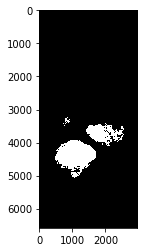

In [12]:
plt.imshow(bg_mask, cmap='gray', vmin=0, vmax=255)

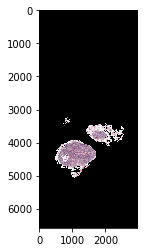

In [13]:
slide_im = slide.read_region((0,0), 5, slide.level_dimensions[5]).convert('RGB') 
plt.imshow(slide_im & np.tile(np.array(bg_mask), (3,1,1)).transpose(1,2,0))

In [14]:
cancer_mask = sc.get_cancer_mask(slide, slide_name, mask_dir, annot_xml_filepath) if not negative_mode else None

[2019-12-03 11:02:54][I][runner] Creating annotation mask.


In [14]:
print(sc.step_size)

32


In [15]:
coord_0_x = 31744
coord_0_y = 146560
coord_x = coord_0_x // scaling_factor
coord_y = coord_0_y // scaling_factor
print('Important coords: (' + str(coord_x) + ',' + str(coord_y) +')')

Important coords: (7935.0,36639.0)


In [23]:
effective_scaling_factor = bg_scaling_factor / scaling_factor   # scaling between sampling and bg levels
print('ESF: {}'.format(effective_scaling_factor))

ESF: 8.001315068676217


In [29]:
tile_mask = bg_mask.crop((int(coord_x // effective_scaling_factor), 
                          int(coord_y // effective_scaling_factor), 
                          int((coord_x+sc.tile_size) // effective_scaling_factor), 
                          int((coord_y+sc.tile_size) // effective_scaling_factor)))
print(tile_mask.size)

(12, 12)


Tissue coverage:  1.0
TISSUE


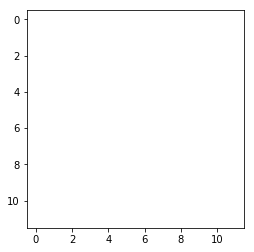

In [33]:
plt.imshow(tile_mask, cmap='gray', vmin=0, vmax=1)
tissue_coverage = np.min([1.0, sc.tissue_percent(np.array(tile_mask), int(sc.tile_size // effective_scaling_factor))])
print('Tissue coverage: ', tissue_coverage)
if not sc.min_bg <= tissue_coverage <= sc.max_bg:
    print('BACKGROUND')
else:
    print('TISSUE')

In [19]:
tile_label, center_label = sc.determine_label(cancer_mask, coord_x, coord_y, negative_mode)
print('Tile label: ', tile_label)
print('Center label: ', center_label)

Tile label:  1.0
Center label:  True
